# Unveiling London's mobility patterns with Boris Bikes

> Using Transport for London's data on the Santander Bike Scheme to understand how Londoners move around the city

- toc: false
- authors: James Bishop, Markus Hauru, Federico Nanni, Camila Rangel Smith
- categories: [data exploration, data wrangling, data visualisation, urban analytics]
- image: images/story_previews/2023-07-07-Boris-Bikes.png

**Authors:**
- James Bishop
- Markus Hauru
- Federico Nanni
- Camila Rangel Smith

**Reviewers:**
- Ryan Chan
- David Llewellyn-Jones

**Published:** 2023-07-07

# Introduction


In recent years, London has become a much more cyclist-friendly city, thanks in large part to the Transport for London (TfL) Santander Bike Scheme. The scheme was launched in July 2010 (until 2015 the scheme was sponsored by Barclays Bank) and has since become a popular way for Londoners to get around the city. 

The bicycles, colloquially called "Boris Bikes" after the Mayor of London at the time, are part of a sharing system that allows users to pick them up and drop them off at designated docking stations located around London. The bikes are available 24 hours a day, seven days a week, and are used by Londoners and visitors for a variety of journeys, from commuting to leisure rides. Riders can purchase access to the scheme through a range of payment options, including yearly and monthly memberships as well as a day pass. [The scheme also offers a variety of discounts for students, workers of the National Health Service and users of the Cycle to work scheme](https://tfl.gov.uk/modes/cycling/santander-cycles/register-for-your-own-key).

The scheme has been praised for its convenience and affordability and has become a popular way for Londoners to get around the city. According to some [studies](https://www.bmj.com/content/348/bmj.g425) it has had a positive effect on the health of its users by increasing physical activity within the capital. As reported by TfL in mid 2022 more than 111.2 million journeys had been made using the cycles, with [the record for cycle hires](https://tfl.gov.uk/info-for/media/press-releases/2015/july/london-celebrates-five-successful-years-of-the-mayor-s-flagship-cycle-hire-sche) in a single day being 73,000. In October 2022, TfL introduced new e-bikes to the scheme, the [first docked e-bikes in London](https://tfl.gov.uk/info-for/media/press-releases/2022/october/docked-e-bikes-now-available-for-hire-as-part-of-london-s-record-breaking-santander-cycles-scheme).

In addition to this, the cycling infrastructure has played an essential role in London, as well as in many other cities, during the pandemic. With many people avoiding public transport and opting to cycle instead, the Boris bikes were used by many commuters on their journeys. Several other city bike schemes have also become available in London, such as [Lime, Tier, etc.](https://secretldn.com/bike-hire-london/), but they are all much more recent and don't have data publicly available the way Boris Bikes do. 

For these reasons, in this Turing Data Story we have decided to study the data set provided by TfL on Boris Bike journeys. It is an opportunity to analyse how the scheme and its use has changed over time and how it has affected the daily lives of Londoners. We will explore general statistics of bike usage such as how the number of bikes in use and their utilisation has changed; the different ways bikes are used and move around the city; and try to understand the patterns of mobility in London.

## Table of Contents

* [Data description](#data-description)
* [Statistics on bike usage](#statistics)
* [A day in the life of a bike](#day)
* [Bike mobility patterns](#mobility)
* [Conclusions](#conclusions)

Before we get to actual work, in the below cell we import all the Python modules we will need in the course of this story, and set a couple of global constants related to e.g. plotting. In addition to running `pip install -r requirements.txt` to install all these dependencies, you may find that you need to install some binary libraries that the geospatial packages depend on. On the authors' Macs `brew install gdal` does the trick.

In [52]:
import datetime
import json
import os
import pickle
import re
import urllib

import community
import contextily as cx
import folium
import matplotlib
import matplotlib.pyplot as plt
import movingpandas as mpd
import networkx as nx
import numpy as np
import pandas as pd
import pyproj
import requests as requests
import seaborn as sns
from folium.plugins import TimestampedGeoJson
from geopandas import GeoDataFrame, points_from_xy
from shapely.geometry import Point
from tqdm.auto import tqdm

# Set the default figure size
plt.rcParams["figure.figsize"] = (10, 6)

# This sets the environment variable PROJ_LIB to the directory containing the data files
# needed by the pyproj library. This allows the pyproj library to find and access the
# data files it needs.

os.environ["PROJ_LIB"] = pyproj.datadir.get_data_dir()

The story makes use of the [Cycle Streets API](https://www.cyclestreets.net), which in turn uses [OpenStreetMap](https://www.openstreetmap.org/copyright) map data.

# Data description <a class="anchor" id="data-description"></a>

TfL provides an [open data set](https://cycling.data.tfl.gov.uk/) containing all bike journeys since the launch of the scheme in July 2010, available under a permissive [licence](https://tfl.gov.uk/corporate/terms-and-conditions/transport-data-service). The data set has information about each journey such as start and end stations, start and end dates and times, and the duration of the journey. For this story we are using all available data from the start of the scheme to January 2022.

An example of the format of the data provided by TfL is the following:

| Rental Id	 |Duration |	Bike Id|	End Date|	EndStation Id|	EndStation Name|	Start Date|	StartStation Id	|Start Station Name|
|--------  | -------- | -------- |-------- |-------- |-------- |-------- |-------- |-------- |
| 85290142 | 300| 7125 |25/03/2019 13:37 |624 |Courland Grove, Wandsworth Road |25/03/2019 13:32 |772 |Binfield Road, Stockwell |
| 85323786 | 180	|6711 | 26/03/2019 14:25  |400 | George Street, Marylebone  |26/03/2019 14:22 |6|Broadcasting House, Marylebone|

Note that the columns End Date and Start Date are actually datetimes rather than dates. The Duration column is in seconds.

## Data processing and cleaning

The data covers a wide time range, and the format has seen several small changes in that period. Consequently having a single table with all the journey data requires a bit of cleaning, harmonising, and general data-wrangling. Some examples of the kinds of things one needs to deal with are:
* Data files are provided at the weekly level and need to be downloaded programatically from the TfL web page,
* Most of the data comes in CSV files, but some time periods are in Excel spreadsheets,
* Station name (string) to station ID (integer) mappings are many-to-many: The same station often has slightly differently spelled names in different files, sometimes the same station has gone by several IDs, and sometimes the same ID has been used for entirely different stations at different times,
* Station IDs are integers, except for one (there's always one isn't there?) that is a string,
* Some rows have missing data,
* Columns in CSV files have changed names a few times.

Dealing with all this is a boring affair and can deviate from the purpose of this data story, and therefore we have decided to do the cleaning elsewhere. However, if you enjoy boredom, you can find our data-cleaning script [here](https://github.com/alan-turing-institute/pfeffel/blob/main/src/clean_data.py).

In the end, we have around 100M bicycle journeys of cleaned data (we had to drop a negligibly small number of rows that were missing/malformatted beyond repair), all in one pandas DataFrame, that is, thankfully, at around 7 gigabytes just small enough to handle in memory on a modern laptop.

In addition to bike journeys, we also make use of another data set the TfL provides, that has coordinates for the locations of all stations.

We have uploaded all the necessary data sets for this story onto Zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7551619.svg)](https://doi.org/10.5281/zenodo.7551619). The below cell downloads the cleaned data into a subfolder called `data`.

In [2]:
# This downloads the data from Zenodo if it is not already present in the data folder
# The ! syntax is a IPython Notebook specialty, that allows running shell commands
# in the middle of a Python control structure.
if not os.path.exists("data"):
    !mkdir data
if not os.path.exists("data/BorisBikes_journeys_cleaned_data.pickle"):
    !wget https://zenodo.org/record/7509993/files/BorisBikes_journeys_cleaned_data.pickle -P data/
if not os.path.exists("data/BorisBikes_station_names.pickle"):
    !wget https://zenodo.org/record/7509993/files/BorisBikes_station_names.pickle -P data/
if not os.path.exists("data/BorisBikes_stations_coordinates.json"):
    !wget https://zenodo.org/record/7509993/files/BorisBikes_stations_coordinates.json -P data/

## Load processed data 

Let's load the data into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and take a look at it.

In [3]:
RAW = "data/BorisBikes_journeys_cleaned_data.pickle"
LOCATION_REF = "data/BorisBikes_stations_coordinates.json"

station_locations_df = pd.read_json(LOCATION_REF).T
station_locations_df.head()

lat       lon
85  51.500647 -0.078600
86  51.489479 -0.115156
87  51.516468 -0.079684
88  51.518587 -0.132053
89  51.526250 -0.123509

In [4]:
# load raw data
df = pd.read_pickle(RAW)
len(df)

97656969

As mentioned above we have around 100 million rows.

Some trips have bogus dates from before the scheme started, or from the future. We drop those rows from our data set. We do allow for journeys that have no end date, since there's quite a lot of them, and presumably they could mark bikes that were lost or broke down.

In [5]:
EARLIEST_DATE = datetime.datetime(2010, 1, 1)
# filter out of range dates
df = df[df["start_date"] > EARLIEST_DATE]
# allow NA for end dates
df = df[(df["end_date"] > EARLIEST_DATE) | df["end_date"].isna()]
# also drop entries where start date is after the end date
df = df[df["start_date"] < df["end_date"]]
# recalc duration
df["duration"] = df["end_date"] - df["start_date"]

We still have the vast majority of our data left after this:

In [6]:
len(df)

97120201

The last journey date observed in our data set is the following:

In [7]:
max(df["end_date"])

Timestamp('2022-01-04 23:59:00')

# Statistics on bike usage <a class="anchor" id="statistics"></a>


After some basic cleaning in the sections above we can start looking at some statistics. Let's see how many unique bikes we have in our data set:

In [8]:
df["bike_id"].nunique()

21149

We assume that every one of those 21 thousand unique bike IDs corresponds to a different physical bike. If a bike has changed its ID or an ID has been reused, we have no way of telling that, and we assume it does not happen.

Now, let's look at the bike with the most trips in our data set: 

In [9]:
bike_groups = df.groupby("bike_id")

# bike with the most trips
# pick arbitrary column (without nulls) to get counts
group_counts = bike_groups.count()["filename"]
b_id = group_counts.idxmax()
n_trips = group_counts.loc[b_id]

print(
    f"""
bike with most trips: {b_id}
did {n_trips} trips
"""
)


bike with most trips: 8875
did 10034 trips



Trips vary in length, so let's also see what the maximum number of hours a bike has been used is, summing up the durations of all its trips:

In [10]:
# bike with longest sum duration of trips
group_sums = bike_groups["duration"].sum()
b_id = group_sums.idxmax()
d_sum = group_sums.loc[b_id]

print(
    f"""
bike with longest sum duration of trips: {b_id}
total of {d_sum} of time in use
"""
)


bike with longest sum duration of trips: 2143
total of 215 days 05:46:00 of time in use



At the macro level we can look at the distribution of the durations of the journeys (here we have decided to exclude outliers representing very long journeys to focus on the bulk of the distribution). 

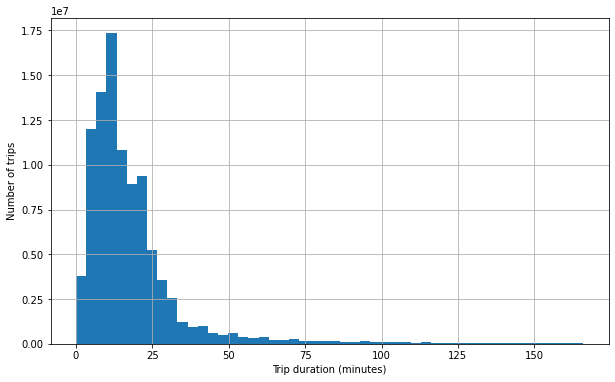

In [53]:
fig, ax = plt.subplots()
# 10k seconds is a bit less than 3 hours. We use it as the threshold
# to exclude anomalously long trips.
mask_long_trips = df["duration"].dt.seconds < 10000
df_duration_minutes = df[mask_long_trips]["duration"].dt.seconds / 60
ax = df_duration_minutes.hist(bins=50)
plt.xlabel("Trip duration (minutes)")
plt.ylabel("Number of trips")
plt.show()

We can see in the figure above that the bikes are used mostly for short journeys, with the core of the distribution centered around journeys ~15 minutes long, and most of the journeys are less than 30 minutes. The latter is most likely due to a cut-off where trips get more expensive after the 30 minute mark.

## Long-lived bikes

We can use this distribution to calculate the average lifetime of a bike. We define as lifetime the time period in which a bike is present (has recorded trips) in our data set.

To do this, for a given bike we find the earliest start date and the latest end date of the bike available in the data set. 

In [12]:
bike_start = bike_groups["start_date"].first()
bike_end = bike_groups["end_date"].last()
bike_lifetime = bike_end - bike_start

The distribution of the lifetimes in days is the following:

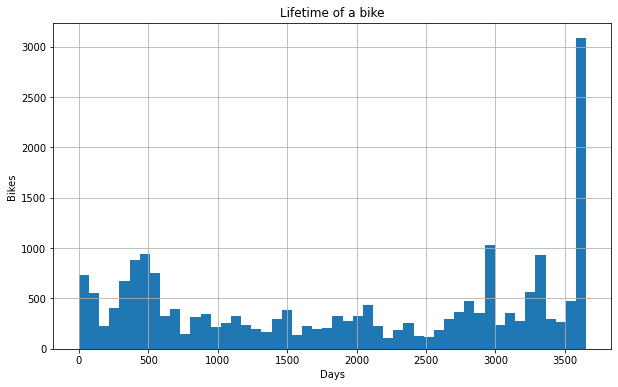

In [54]:
fig, ax = plt.subplots()
ax = bike_lifetime.dt.days.hist(bins=50)
plt.xlabel("Days")
plt.ylabel("Bikes")
plt.title("Lifetime of a bike")
plt.show()

The distribution looks quite flat, with a large peak on around ~3600 days. These are very likely bikes that have been part of the scheme from the beginning.

Now, let's see what the average utilisation of a bike is. By this we mean the total ride duration divided by its total lifetime.

In [14]:
duration_sums = bike_groups["duration"].sum()
bike_utilisation = duration_sums / bike_lifetime

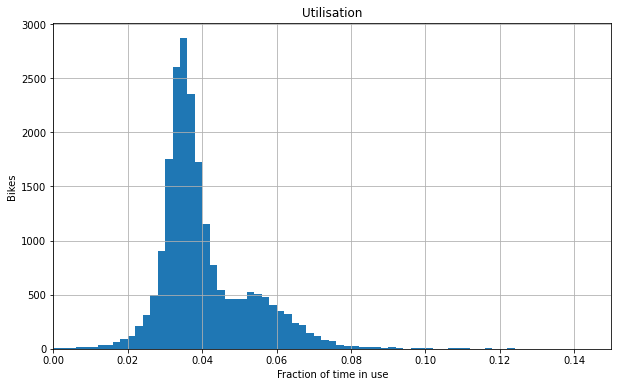

In [55]:
fig, ax = plt.subplots()
ax = bike_utilisation.hist(bins=500)
plt.xlim([0, 0.15])
plt.xlabel("Fraction of time in use")
plt.ylabel("Bikes")
plt.title("Utilisation")
plt.show()

The distribution above shows that during its lifetime an average bike gets used around 45 minutes per day. 

We must note the caveat that the lifetime definition does not consider the time bikes are in maintenance or not in service for any given reason. As a consequence this utilisation metric may be an underestimate, because it counts any downtime as the bike being available but not in use. 

### Time series of bike usage

The number of bikes and stations has evolved since the beginning of the scheme, with more being added every year.
Furthermore, London has changed since 2010 and bike usage might have changed with it. 
Hence we'll take a look at the number of bikes and stations available and bike utilisation as functions of time. 

Our utilisation measure here will be slightly different to our previous figure. Previously we looked at the utilisation at the bike level and averaged this. Now, we're looking at sum of use over the entire fleet and dividing this by the max possible usage per month (all bikes in use 24/7).

Let's start by creating a monthly index for the time series:


In [16]:
# don't want to incude first and last months as may be incomplete, use in filter later
incomplete_months = df["start_date"].iloc[[0, -1]].dt.to_period("M")
# create a complete monthly index that covers ALL months in period
complete_monthly_index = pd.date_range(
    start=df["start_date"].iloc[0], end=df["end_date"].iloc[-1], freq="M"
).to_period("M")

Next we create a function that counts how many bikes or stations are in use in a given month. 


In [17]:
def calc_alive_per_month(starts, ends, incomplete_months, complete_monthly_index):
    starts_per_month = starts.dt.to_period("M").value_counts()
    ends_per_month = ends.dt.to_period("M").value_counts()

    counts_df = (
        complete_monthly_index.to_frame(name="foo")
        .join(starts_per_month)
        .join(ends_per_month)
        .sort_index()
        .fillna(0)
    )
    # ending items should only be counted at the start of next month, so shift
    counts_df["end_date"] = counts_df["end_date"].shift(fill_value=0)

    alive_per_month = counts_df["start_date"].cumsum() - counts_df["end_date"].cumsum()
    return alive_per_month[~alive_per_month.index.isin(incomplete_months)]

Using the function defined above we create a dataframe of bikes available at the monthly level.


In [18]:
alive_bikes_per_month = calc_alive_per_month(
    starts=bike_start,
    ends=bike_end,
    incomplete_months=incomplete_months,
    complete_monthly_index=complete_monthly_index,
)

We are also interested in seeing the total usage of the bikes per month in terms of the sum of the duration of each journey and the total utilisation. 

In [19]:
duration_sums_per_month = (
    df[["duration"]].groupby(df["start_date"].dt.to_period("M"))["duration"].sum()
)
duration_sums_per_month = duration_sums_per_month.to_frame()
duration_sums_per_month["max_possible_duration"] = duration_sums_per_month.index.map(
    lambda x: x.end_time - x.start_time
)
utilisation_per_month = (
    duration_sums_per_month["duration"]
    / duration_sums_per_month["max_possible_duration"]
    / alive_bikes_per_month
)
# remove incomplete months
utilisation_per_month = utilisation_per_month[
    ~utilisation_per_month.index.isin(incomplete_months)
]

Let's also look at how many stations are available in each month. 


In [20]:
station_groups = df.groupby("start_station_id")
# relies on time ordering of df via rental_id
station_start = station_groups["start_date"].first()
station_end = station_groups["end_date"].last()

In [21]:
alive_stations_per_month = calc_alive_per_month(
    starts=station_start,
    ends=station_end,
    incomplete_months=incomplete_months,
    complete_monthly_index=complete_monthly_index,
)

Let's merge our bike usage dataframe with our new station usage data. This results in a monthly indexed dataframe that we can use for visualisation later on:

In [22]:
# forward fill gaps
stats_df = (
    complete_monthly_index.to_frame(name="date")
    .join(alive_bikes_per_month.rename("alive_bikes"))
    .join(alive_stations_per_month.rename("alive_stations"))
    .join(utilisation_per_month.rename("utilisation"))
    .fillna(method="ffill")
)

In [23]:
stats_df.head()

date  alive_bikes  alive_stations  utilisation
2012-01  2012-01          NaN             NaN          NaN
2012-02  2012-02       6592.0           521.0     0.030871
2012-03  2012-03       8659.0           560.0     0.046002
2012-04  2012-04       8663.0           567.0     0.036303
2012-05  2012-05       8813.0           569.0     0.050691

Let's look at our time series from March 2012.

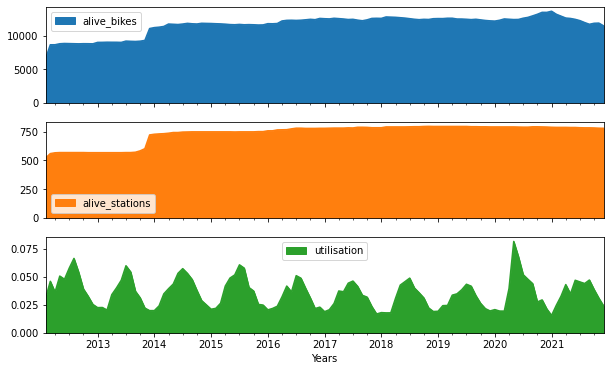

In [56]:
stats_df[1:].plot.area(subplots=True)
plt.xlabel("Years")
plt.show()

We can see clearly the expansion of the scheme in 2012 where new stations were added to [include East London](https://www.theguardian.com/uk/2011/feb/01/bike-hire-scheme-east-london-spring-2012). Another prominent feature is the annual periodicity, where bike utilisation is, unsurprisingly, higher in the summer. It ranges from roughly ~2% in most winters to 5-6% in the summers, so at any given moment, on average something between 1-in-20 to 1-in-50 bikes are being ridden.

The effect of the pandemic in 2020 is also evident in data as a spike in utilisation in 2020, which generally seems to have slowly decreased after the excitement of the first couple of years of the scheme. Note that the number of "alive" (in use) bikes also has a temporary spike in the pandemic, which we guess is the TfL responding to increased demand.

# Looking at the behaviour of individual bikes

For the next section of the story we are interested in looking at the pattern of movements of bikes. For this we want to follow the different journeys a bike can take during a time period. For this we need to define a new concept which we call a chain. A chain is a sequence of trips for a given bike, where the start location matches the previous end location. In other words, a new chain starts every time a bike moves to a new location without the journey appearing in the database, such as when moved by TfL or taken in for repairs.

Creating chains for all available bikes in this data set can be time consuming and we are only interested in a few examples. We will get only a subset of the chains: let's look at bikes with the longest lifetimes.

Let's get the top ten longest living bikes in our data set.

In [25]:
top_ten_lived_bike_ids = bike_lifetime.sort_values()[-10:].index.values

In [26]:
top_ten_bike_subset = df[df["bike_id"].isin(top_ten_lived_bike_ids)].copy()

Let's create a function that for a given bike creates a chain ID for each sequence of journeys. The chain ID changes once the starting station of a journey is not the same as the end station from the previous one.


In [27]:
def add_chains(bike_id, bike_group):
    # note fillna for end station to allow for comparison to NA
    breaks = bike_group[
        bike_group["start_station_id"]
        != bike_group.shift()["end_station_id"].fillna(-1)
    ]
    break_indices = breaks.index.values

    chains = list()
    for i, (start, end) in enumerate(
        zip([None, *break_indices], [*break_indices, None])
    ):
        chain = bike_group.loc[start:end]
        chain_id = f"{bike_id}_{i}"
        chains.append(pd.Series(chain_id, index=chain.index))
    return pd.concat(chains)

Using the function defined above, lets get the chains for the top ten longest lived bikes.


In [28]:
chains = list()
for k, g in tqdm(top_ten_bike_subset.groupby("bike_id")):
    g = bike_groups.get_group(k)
    chains.append(add_chains(bike_id=k, bike_group=g))

top_ten_bike_subset = top_ten_bike_subset.join(pd.concat(chains).rename("chain_id"))

# chain creation can create some duplicate rows, that are removed here.
top_ten_bike_subset = top_ten_bike_subset[~top_ten_bike_subset.index.duplicated(keep='first')] 

  0%|          | 0/10 [00:00<?, ?it/s]

Let's look at number of journeys a typical chain can have (for the top ten longest lived bikes).

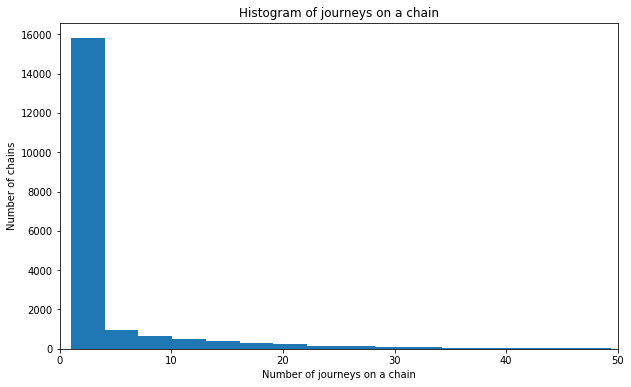

In [57]:
# Plotting the histogram
plt.hist(top_ten_bike_subset.groupby('chain_id').size(), bins=40)
plt.xlim([0, 50])
plt.title('Histogram of journeys on a chain')
plt.xlabel('Number of journeys on a chain')
plt.ylabel('Number of chains')
plt.show()

It can be quite surprising to see bikes being frequently transported between stations by means other than cyclists, possibly by TfL trucks. However, it's important to note that this distribution only contains data from the top ten longest-lived bikes and may not accurately represent the overall fleet of bikes.

# A day in the life of a bike <a class="anchor" id="day"></a>


Now that we have "chains" associated to our long lived bikes we can use them to follow them around for a given time period. We are interested to see how they move around the city. 


There is still some missingness in our data set, in the form of stations IDs not linked to our station data set. Let's write a simple function to remove journeys where the station information is missing. 


In [30]:
def remove_missing_stations(df, stations):
    def check_id(row, stations):
        start_id = str(int(row["start_station_id"]))
        end_id = str(int(row["end_station_id"]))
        if str(start_id) in stations.keys() and str(end_id) in stations.keys():
            return True
        return False

    df["check_stations_ids"] = df.apply(lambda row: check_id(row, stations), axis=1)
    df = df[df.check_stations_ids.eq(True)]
    return df

In [31]:
with open("data/BorisBikes_stations_coordinates.json") as f:
    stations = json.load(f)

data = remove_missing_stations(top_ten_bike_subset, stations)
data.head()

duration  bike_id            end_date  end_station_id  \
rental_id                                                                
9340768   0 days 00:20:00      893 2012-01-04 00:20:00             169   
9343209   0 days 00:17:00     3278 2012-01-04 00:23:00             114   
9343534   0 days 00:18:00      540 2012-01-04 00:45:00             211   
9344212   0 days 00:15:00       17 2012-01-04 00:20:00             340   
9346348   0 days 00:19:00      791 2012-01-04 00:25:00              33   

                                  end_station_name          start_date  \
rental_id                                                                
9340768               Porchester Place, Paddington 2012-01-04 00:00:00   
9343209    Park Road (Baker Street), Regent's Park 2012-01-04 00:06:00   
9343534               Cadogan Place, Knightsbridge 2012-01-04 00:27:00   
9344212               Bank of England Museum, Bank 2012-01-04 00:05:00   
9346348                Altab Ali Park, Whitechapel 2012-01-04 00:06:00   

           start_station_id             start_station_name  \
rental_id                                                    
9340768                 224  Queensway, Kensington Gardens   
9343209                  49         Curzon Street, Mayfair   
9343534                  64      William IV Street, Strand   
9344212                  88     Bayley Street , Bloomsbury   
9346348                  48    Godliman Street, St. Paul's   

                                                    filename chain_id  \
rental_id                                                               
9340768    ../bikes/1. Journey Data Extract 04Jan-31Jan 1...    893_0   
9343209    ../bikes/1. Journey Data Extract 04Jan-31Jan 1...   3278_0   
9343534    ../bikes/1. Journey Data Extract 04Jan-31Jan 1...    540_0   
9344212    ../bikes/1. Journey Data Extract 04Jan-31Jan 1...     17_0   
9346348    ../bikes/1. Journey Data Extract 04Jan-31Jan 1...    791_0   

           check_stations_ids  
rental_id                      
9340768                  True  
9343209                  True  
9343534                  True  
9344212                  True  
9346348                  True

Now we can make this code a bit more formal by building objects that represent Bikes and Trips. 

A trip is a journey between two stations. The data from TfL only provides a journey starting and final station but we can use the [Cycle Streets API](https://www.cyclestreets.net/api/) to build the most probable route between two points given the duration of that journey.

Our Trip object (containing the journey and route data) is defined as the following:

In [32]:
class Trip:
    def __init__(self, data, bike_id, trip_id, station_data):
        df = data[data.index == trip_id]

        self.init_station = {
            "name": df.start_station_name.values[0],
            "id": df.start_station_id.values[0],
            "latitude": station_data[str(int(df.start_station_id.values[0]))]["lat"],
            "longitude": station_data[str(int(df.start_station_id.values[0]))]["lon"],
        }
        self.end_station = {
            "name": df.end_station_name.values[0],
            "id": df.end_station_id.values[0],
            "latitude": station_data[str(int(df.end_station_id.values[0]))]["lat"],
            "longitude": station_data[str(int(df.end_station_id.values[0]))]["lon"],
        }
        self.bike = df.bike_id.values[0]
        self.duration = df.duration.values[0]
        self.date = {
            "start": df.start_date.values[0],
            "end": df.end_date.values[0],
        }
        self.circular = self.init_station == self.end_station
        self.route = {}
        self.bike_id = bike_id
        self.trip_id = trip_id

    def get_route(self, key, route_path="routes/"):

        if not os.path.exists(route_path):
            os.makedirs(route_path)

        route_file_path = (
            route_path + str(self.bike_id) + "_" + str(self.trip_id) + ".json"
        )
        if os.path.isfile(route_file_path):
            with open(route_file_path, "r") as fp:
                data = json.load(fp)
                self.route = data
        else:
            if self.circular:
                self.route = {}

            else:
                plans = ["balanced", "fastest", "quietest", "shortest"]

                closest_time = None
                trip_data = {}

                for plan in plans:
                    itinerarypoints = "{},{}|{},{}".format(
                        self.init_station["longitude"],
                        self.init_station["latitude"],
                        self.end_station["longitude"],
                        self.end_station["latitude"],
                    )
                    name = "https://www.cyclestreets.net/api/journey.json?" + urllib.parse.urlencode(
                        {
                            "key": key,
                            "itinerarypoints": itinerarypoints,
                            "plan": plan,
                        }
                    )
                    data = requests.get(name).json()["marker"][0]["@attributes"]
                    time = int(data["time"])
                    if closest_time is None:
                        closest_time = abs(time - self.duration)
                        trip_data = data

                    elif abs(self.duration - time) < closest_time:
                        closest_time = abs(time - self.duration)
                        trip_data = data

                self.route = trip_data

            with open(route_file_path, "w") as fp:
                json.dump(self.route, fp)

A Bike object represents a bike identified by its ID. The Bike object has methods that allow you to fetch its "story" which is made up of all the trips recorded in the data and routes obtained from Cycle Streets.

In order to fetch data from the Cycle Streets API you need to apply for access and obtain a key.

In [37]:
# you should store the key in a file called cycle_street_key.txt inside the data folder
key = open("data/cycle_street_key.txt", "r").readline()

In [38]:
class Bike:
    def __init__(self, id):
        self.id = id

    def get_chains(self, stations):
        chain_ids = self.bike_rides.chain_id.to_list()
        chains = {}
        for chain_id in chain_ids:
            chain_rides = self.bike_rides[self.bike_rides["chain_id"] == chain_id]
            chains[chain_id] = [
                Trip(chain_rides, self.id, trip_id, stations)
                for trip_id in chain_rides.index
            ]
        self.chains = chains

    def get_story(self, dataset, stations, key):
        bike_rides = dataset[dataset["bike_id"] == self.id]
        self.bike_rides = bike_rides
        self.get_chains(stations)

        for chain_id, chain in self.chains.items():

            for counter, trip in enumerate(chain):
                trip.get_route(key)
                if trip.route == {}:
                    continue

We can visualise the journeys of a bike on a map using the libraries [Folium](https://pypi.org/project/folium/) and [movingpandas](https://pypi.org/project/movingpandas/).

In [39]:
def get_colours(steps):
    colours = sns.color_palette("mako").as_hex()
    rev_colours = sns.color_palette("mako").as_hex()
    rev_colours.reverse()
    colours = rev_colours + colours
    while len(colours) < steps:
        colours += colours
    return colours


def get_trajectory(bike_id, route_folder="routes/"):

    trip_list = [
        filename
        for filename in sorted(os.listdir(route_folder))
        if str(bike_id) + "_" in filename
    ]

    times = []
    geometry = []
    colours = []

    many_colurs = get_colours(len(trip_list))

    for c in range(len(trip_list)):
        chain = trip_list[c]
        with open(route_folder + chain) as f:
            d = json.load(f)
        if len(d) > 0:
            geometry += [
                Point([float(y) for y in x.split(",")])
                for x in d["coordinates"].split(" ")
            ]
            if len(times) == 0:
                time_now = datetime.datetime.now()
            else:
                time_now = times[-1]
            times += [
                time_now + datetime.timedelta(seconds=1 * t + 1)
                for t in range(len(d["coordinates"].split(" ")))
            ]
            colours += [many_colurs[c] for x in range(len(d["coordinates"].split(" ")))]

    df = pd.DataFrame()

    df["t"] = times
    df["trajectory_id"] = [1 for x in range(len(geometry))]
    df["sequence"] = [x + 1 for x in range(len(geometry))]
    df["colour"] = colours

    gdf = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    gdf = gdf.set_index("t")

    trajs = mpd.TrajectoryCollection(gdf, "trajectory_id")
    trajs = mpd.MinTimeDeltaGeneralizer(trajs).generalize(
        tolerance=datetime.timedelta(seconds=1)
    )
    traj = trajs.trajectories[0]
    return traj


def draw_map(traj):
    features = traj_to_timestamped_geojson(traj)
    # Create base map
    London = [51.506949, -0.122876]
    map = folium.Map(location=London, zoom_start=12, tiles="cartodbpositron")
    TimestampedGeoJson(
        {
            "type": "FeatureCollection",
            "features": features,
        },
        period="PT1S",
        add_last_point=False,
        transition_time=10,
    ).add_to(map)
    return map


def traj_to_timestamped_geojson(trajectory):
    features = []
    df = trajectory.df.copy()
    df["previous_geometry"] = df["geometry"].shift()
    df["time"] = df.index
    df["previous_time"] = df["time"].shift()
    for _, row in df.iloc[1:].iterrows():
        coordinates = [
            [
                row["previous_geometry"].xy[0][0],
                row["previous_geometry"].xy[1][0],
            ],
            [row["geometry"].xy[0][0], row["geometry"].xy[1][0]],
        ]
        times = [row["previous_time"].isoformat(), row["time"].isoformat()]
        features.append(
            {
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": coordinates,
                },
                "properties": {
                    "times": times,
                    "style": {
                        "color": row["colour"],
                        "weight": 5,
                    },
                },
            }
        )
    return features

In [40]:
bike_id = 893
selected_data = data[
    (data["start_date"] > "2020-03-23") & (data["start_date"] < "2020-05-14")
]
bike = Bike(id=bike_id)
bike.get_story(selected_data, stations, key)

In [58]:
traj = get_trajectory(bike_id)
map_trajectory = draw_map(traj)
map_trajectory

 ![Image](../images/story_loaded_images/day-on-the-life-bike.png)

In this map you can see a series of trips done by a single bike during the first lockdown, between March and May 2020. Different colours highlight different journeys. Straight lines jumps in the map mean the bike was moved to another station by TfL and not a cyclist, therefore that chain has ended. This is a static image created for rendering in fast-pages. If you want to see the animated version, take a look at this [nbrreview link](https://nbviewer.org/github/alan-turing-institute/TuringDataStories/blob/master/stories/2022-10-06-Boris-Bikes/2022-10-06-Boris-Bikes.ipynb#day).


If you are running locally you can take a look at the story of other bikes, for instance ID `3278` - you might be surprised by what you find!

# Bike mobility patterns <a class="anchor" id="mobility"></a>

The patterns of mobility observed in this data set can be abstracted using networks built from trips between stations.

We construct a bidirectional weighted graph/[network](https://en.wikipedia.org/wiki/Network_theory) where the nodes are stations and the weight of an edge from station A to station B is the number of trips taken from A to B.
As we'll see below, this reveals some high-level patterns in different regions and around different stations in London, that vary between seasons, weekdays, and times of the day.

For the network analysis, we use the `networkx` package. We start by writing a function that builds a `networkx` network from a dataframe of trip data. A parameter `trip_count_threshold` is used to exclude edges that have a very small weight, to make the analysis computationally more tractable.

In [42]:
def create_network_from_data(df, trip_count_threshold=1e-5):
    trip_counts = (
        (
            df[["start_station_id", "end_station_id", "bike_id"]]
            .groupby(["start_station_id", "end_station_id"])
            .count()
        )
        .reset_index()
        .rename(columns={"bike_id": "trip_count"})
    )
    trip_counts = trip_counts.sort_values("trip_count")
    total_num_trips = trip_counts["trip_count"].sum()

    trip_counts = trip_counts[
        trip_counts["trip_count"] >= trip_count_threshold * total_num_trips
    ]

    graph = nx.from_pandas_edgelist(
        trip_counts,
        source="start_station_id",
        target="end_station_id",
        edge_attr="trip_count",
        create_using=nx.DiGraph,
    )

    return graph

As we will see in a moment, our network, like many naturally occurring networks, has so called communities:
these are clusters of nodes that are strongly linked to each other, and less linked to nodes outside the cluster.
In our case this corresponds to groups of bike docking stations that have a lot of traffic amongst each other.

Network theorists have developed many different kinds of algorithms for detecting community structure in networks.
We use the Louvain algorithm, and its implementation in the `python-louvain` package.
The Louvain algorithm chooses the communities by trying to maximise a metric called modularity, that roughly speaking measures how much total weight there is in edges that are internal to communities, compared to weight in edges that cross from one community to another.
It is a greedy and quite fast (O(N log N)) algorithm, that works by hierarchically grouping densely connected nodes together and replacing them with single nodes that represent small communities, grouping those small communities to form bigger communities, etc.
You can find more details on [Wikipedia](https://en.wikipedia.org/wiki/Louvain_method) or the documentation of the `python-louvain` [package](https://github.com/taynaud/python-louvain).

Below we write a function that does such community detection. Note that we need to ignore the directionality of our graph, i.e. the distinction between bikes going from station A to station B rather than from B to A. This is a limitation of the Louvain algorithm, but for community-detection purposes the directionality isn't important.


In [43]:
def network_community_detection(graph, edge_weight):
    graph_undirected = nx.Graph()
    undirected_edges = set(sorted(graph.edges))
    for edge in undirected_edges:
        reverse_edge = (edge[1], edge[0])
        trip_count = graph.edges[edge][edge_weight]
        if reverse_edge in graph.edges:
            trip_count += graph.edges[reverse_edge][edge_weight]
        graph_undirected.add_edge(edge[0], edge[1], trip_count=trip_count)

    partition = community.best_partition(graph_undirected, weight=edge_weight)
    df_partition = pd.DataFrame(partition, index=[0]).T.reset_index()
    df_partition.columns = ["id", "partition"]
    return df_partition

Finally a function for visualising these graphs of bike trips and their communities on a map, together with some supporting functions to aid in that job.


In [44]:
STATION_NAMES_FILE = "data/BorisBikes_station_names.pickle"
STATION_COORDS_FILE = LOCATION_REF

LABEL_STATIONS = [
    "Belgrove Street",
    "Waterloo Station 3",
    "Hyde Park Corner",
    "Aquatic Centre",
    "Bethnal Green Road",
    "Natural History Museum",
    "Kennington Oval",
    "Mudchute DLR",
]


def get_station_name(id):
    with open(STATION_NAMES_FILE, "rb") as f:
        station_allnames = pickle.load(f)

    name = sorted(station_allnames[id])[0]
    name = re.split(";|,|:", name)[0].strip()
    return name


def get_node_info(graph):
    with open(STATION_COORDS_FILE, "r") as f:
        station_latlon = json.load(f)

    nodes = graph.nodes()

    pos = [station_latlon[str(int(node))] for node in nodes]
    pos = [(p["lon"], p["lat"]) for p in pos]

    station_sizes = [i[1] for i in list(graph.degree(weight="trip_count"))]

    labels = [get_station_name(int(node)) for node in nodes]

    nodes_df = pd.DataFrame(
        {"id": list(nodes), "pos": pos, "size": station_sizes, "name": labels}
    )

    return nodes_df


def scale_range(values, min_scaled, max_scaled):
    values = np.array(values)
    if min_scaled is not None:
        max_value = np.max(values)
        min_value = np.min(values)
        mult_coeff = (max_scaled - min_scaled) / (max_value - min_value)
        add_coeff = (max_value * min_scaled - min_value * max_scaled) / (
            max_value - min_value
        )
        scaled = mult_coeff * values + add_coeff
    else:
        max_value = np.max(values)
        scaled = max_scaled * values / max_value
    return scaled


def drop_stations_without_location(graph):
    with open(STATION_COORDS_FILE, "r") as f:
        station_latlon = json.load(f)
    nodes = tuple(graph.nodes)
    stations_with_location = tuple(map(int, station_latlon.keys()))
    for n in nodes:
        if n not in stations_with_location:
            print(f"Removing node {n} because of missing location data.")
            graph.remove_node(n)
    return None


def create_network_and_map(
    df,
    label_stations=LABEL_STATIONS,
    allow_self_loops=False,
    arrows=True,
    bg_map_zoom=15,
):
    community_graph = create_network_from_data(df)
    drop_stations_without_location(community_graph)
    nodes_info = get_node_info(community_graph)
    visualisation_graph = community_graph.copy()
    if not allow_self_loops:
        visualisation_graph.remove_edges_from(nx.selfloop_edges(community_graph))
    community_df = network_community_detection(community_graph, "trip_count")
    nodes_info = nodes_info.merge(community_df, on="id")
    nodes_info = nodes_info.sort_values(by="size", ascending=False)
    del community_df

    nodes_info["lon"] = [p[0] for p in nodes_info["pos"]]
    nodes_info["lat"] = [p[1] for p in nodes_info["pos"]]

    nodes_info = GeoDataFrame(
        nodes_info,
        geometry=points_from_xy(nodes_info.lon, nodes_info.lat),
        crs="EPSG:4326",
    )
    # Project to UK national grid
    nodes_info = nodes_info.to_crs("EPSG:27700")

    labels = {
        id: name
        for id, name in zip(nodes_info["id"], nodes_info["name"])
        if name in label_stations
    }

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    nodes_info.plot(ax=ax, markersize=1, aspect=None)
    cx.add_basemap(
        ax, crs=nodes_info.crs, source=cx.providers.Stamen.TonerLite, zoom=bg_map_zoom
    )

    xynps = [
        np.array([p.x for p in nodes_info["geometry"]]),
        np.array([p.y for p in nodes_info["geometry"]]),
    ]
    pos = {k: (xynps[0][i], xynps[1][i]) for i, k in enumerate(nodes_info["id"])}

    MAX_NODE_SIZE = 300.0
    MIN_NODE_SIZE = 5.0

    sizes = scale_range(nodes_info["size"], MIN_NODE_SIZE, MAX_NODE_SIZE)
    weights = np.array(
        [visualisation_graph.edges[e]["trip_count"] for e in visualisation_graph.edges]
    )

    MAX_EDGE_WIDTH = 3.0
    MIN_EDGE_WIDTH = None

    weights = scale_range(weights, MIN_EDGE_WIDTH, MAX_EDGE_WIDTH)

    MAX_EDGE_ALPHA = 0.9
    MIN_EDGE_ALPHA = None

    edge_alpha = scale_range(weights, MIN_EDGE_ALPHA, MAX_EDGE_ALPHA)

    # Plots
    nx.draw_networkx_nodes(
        visualisation_graph,
        pos=pos,
        nodelist=nodes_info["id"],
        node_color=nodes_info["partition"],
        alpha=1.0,
        node_size=sizes,
        cmap="tab10",
        ax=ax,
    )
    nx.draw_networkx_edges(
        visualisation_graph,
        pos=pos,
        edge_color="#222222",
        width=weights,
        alpha=edge_alpha,
        arrows=arrows,
        ax=ax,
    )
    nx.draw_networkx_labels(
        visualisation_graph,
        pos=pos,
        labels=labels,
        font_size=12,
        ax=ax,
    )

    return fig, ax, nodes_info

To make the network analysis computationally manageable, we restrict our attention to data from a single year, in this case 2021.

In [45]:
HARD_START_DATE = datetime.datetime(year=2010, month=1, day=1)
start_date = datetime.datetime(year=2021, month=1, day=1)
end_date = datetime.datetime(year=2022, month=1, day=1)
df = df[(df["start_date"] > HARD_START_DATE) & (df["end_date"] > HARD_START_DATE)]
df_year = df[(df["start_date"] > start_date) & (df["start_date"] < end_date)]

**Plot time!**
Below is the network of bike trips aggregated over weekday mornings only, in 2021.
The colours of the nodes mark the different communities as discovered by the Louvain algorithm.
The lines connecting nodes have arrows indicating the direction of travel and their thickness marks the amount of traffic.

Plotting mornings
Number of communities: 5


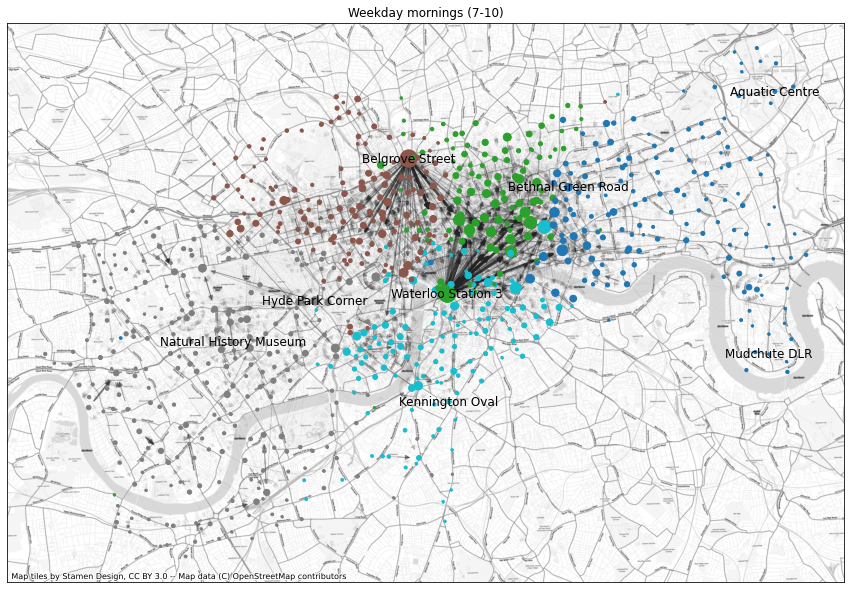

In [46]:
print("Plotting mornings")
df_year_mornings = df[
    df["start_date"].dt.hour.isin([7, 8, 9, 10])
    & df["start_date"].dt.weekday.isin((0, 1, 2, 3, 4))
]
fig, ax, nodes_info = create_network_and_map(df_year_mornings)
num_communities = len(nodes_info["partition"].unique())
print(f"Number of communities: {num_communities}")
plt.title("Weekday mornings (7-10)")
plt.show()

The two most prominent types of weekday morning traffic are outgoing trips from King's Cross/St. Pancras (station called Belgrove Street marked on the map) and from Waterloo. Commuters presumably come in on trains and cover the last bit to their workplace by a Boris Bike. These two types of traffic form two of the communities found by the Louvain algorithm, with the others being less concentrated communities for East, West, and South London.

Below is a similar graph but for weekday afternoons rather than mornings. The dominant patterns are the reverse of the morning traffic, with people going from their offices to the big train stations. A new feature is a community of traffic around Hyde Park, presumably pleasure rides in the afternoon by people on holiday. 

There are some other shifts in the communities marked by the colours, that we find hard to interpret. There's also some instability and randomness in the Louvain algorithm, where if you run it several times sometimes it divides the smaller communities in slightly different ways. The commuter communities are robust, though.


Plotting afternoons
Number of communities: 12


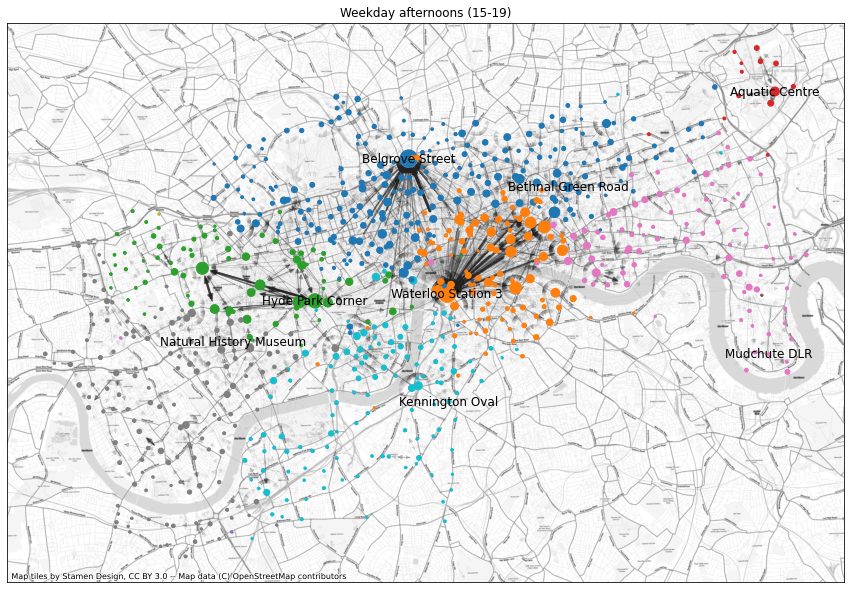

In [47]:
print("Plotting afternoons")
df_year_afternoons = df[
    df["start_date"].dt.hour.isin([15, 16, 17, 18, 19])
    & df["start_date"].dt.weekday.isin((0, 1, 2, 3, 4))
]
fig, ax, nodes_info = create_network_and_map(df_year_afternoons)
num_communities = len(nodes_info["partition"].unique())
print(f"Number of communities: {num_communities}")
plt.title("Weekday afternoons (15-19)")
plt.show()

Below is the same plot but for weekends. Here the most common trips are around Hyde Park and marked by self-loops, where the bike is returned to the same station where it was picked up. We don't know where they were ridden in between, but probably around the park for fun or a picnic. The Olympic Park has a similar loop. The communities again show different regions of London, with people travelling within neighbourhoods, although some of them are somewhat surprising and hard to interpret, with outlier stations way outside the bulk of their communities.


Plotting weekends
Number of communities: 26


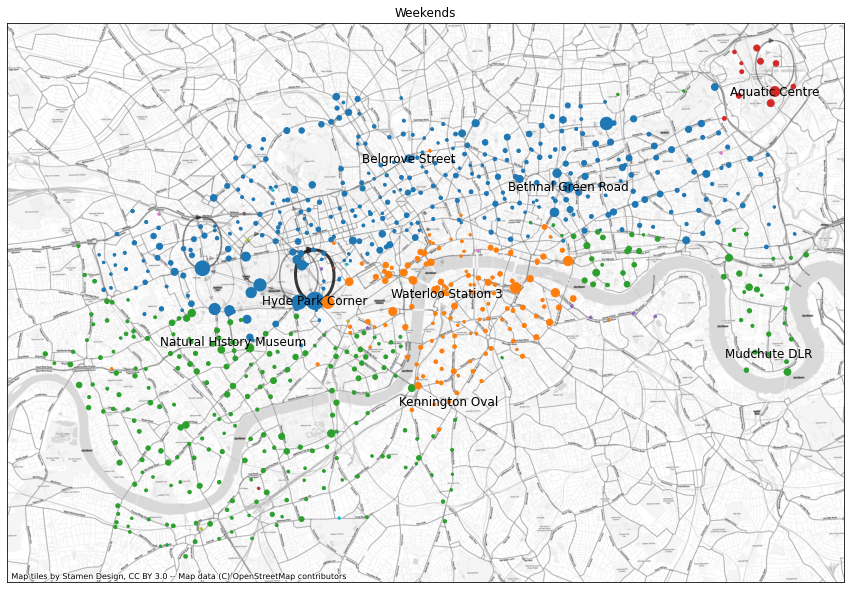

In [59]:
print("Plotting weekends")
df_year_weekends = df[df["start_date"].dt.weekday.isin((5, 6))]
fig, ax, nodes_info = create_network_and_map(
    df_year_weekends,
    allow_self_loops=True,
)
num_communities = len(nodes_info["partition"].unique())
print(f"Number of communities: {num_communities}")
plt.title("Weekends")
plt.show()

Finally, let's see how patterns have changed over time.
Below we create these network plots but this time not for a specific time of day or week, but for specific years: 2013, 2017, 2020, and 2021.

Plotting 2013
Number of communities: 6


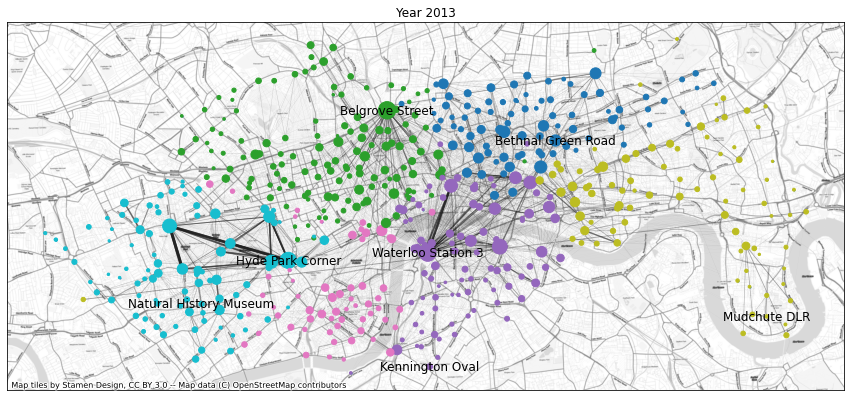

Plotting 2017
Number of communities: 10


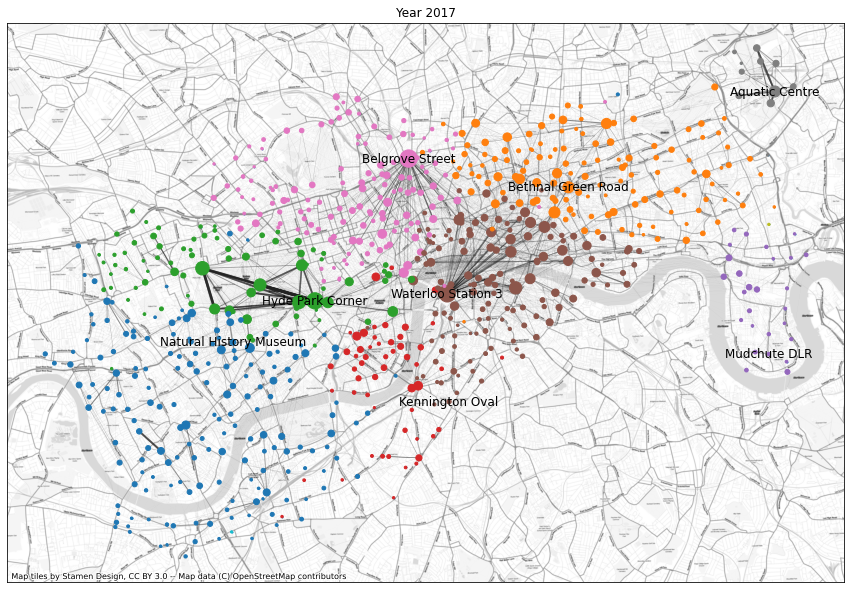

Plotting 2020
Number of communities: 12


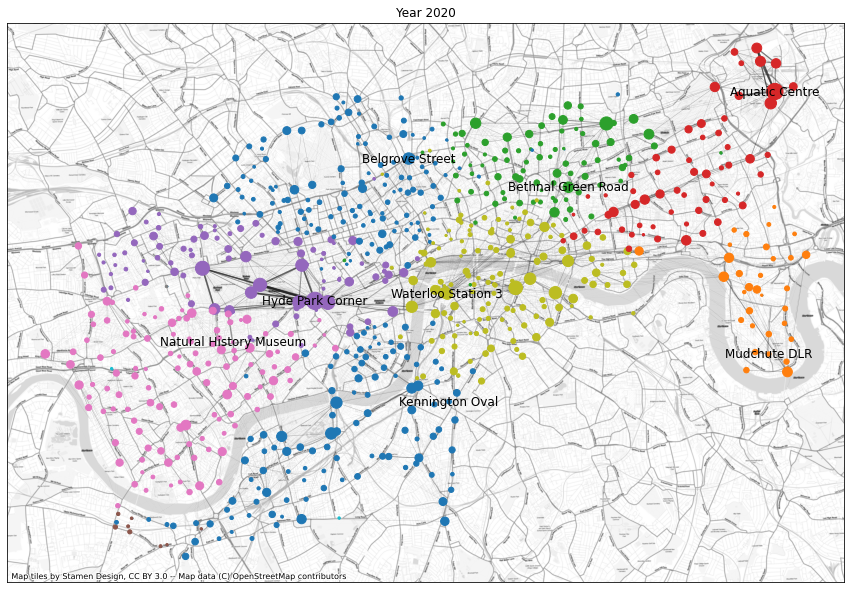

In [49]:
for year in (2013, 2017, 2020):
    print(f"Plotting {year}")
    start_date = datetime.datetime(year=year, month=1, day=1)
    end_date = datetime.datetime(year=year + 1, month=1, day=1)
    df_year = df[(df["start_date"] > start_date) & (df["start_date"] < end_date)]
    fig, ax, nodes_info = create_network_and_map(
        df_year,
        allow_self_loops=False,
        arrows=False,
    )
    num_communities = len(nodes_info["partition"].unique())
    print(f"Number of communities: {num_communities}")
    plt.title(f"Year {year}")
    plt.show()

From 2013 to 2017 the big change is the growth of the network of stations.
Especially in the west and southwest, but also around for instance the Olympic Park, the Boris Bike network grows a lot.

From 2017 to 2020 the notable change is the effect of the pandemic: Most of the commuter traffic from e.g. King's Cross and Waterloo has vanished. The dominant traffic patterns that did survive the pandemic were the rides around Hyde Park and the Olympic Park.

Note that we should be careful in reading too much into the coloured communities and how they've changed from year to year. First of all, the colours bear no particular meaning, and the same community may be coloured differently in different plots. Second, the Louvain algorithm for discovering them is stochastic, and many of the smaller communities might arrange themselves differently by simply running the same cell again. The communities with the most traffic remain robust though.

# Conclusions <a class="anchor" id="conclusions"></a>

In this Turing data story we aimed to use the TfL bike journey data set to understand the usage of Boris Bikes and how it has changed, as well as the patterns in how people move around the capital. This story was born out of a 'Hack week' organised by the [Research Engineering Group](https://www.turing.ac.uk/research-engineering) at the Turing, an annual event in which people from the team get to work on projects or data sets they find interesting. 

Our strategy was to extract some general statistics about bike usage over time, followed by trying to characterise in diffent ways the movements of some long-lived bikes, and finally to use network analysis techniques to abstract these movements into high level patterns of behaviour.

Among other things, the analysis very clearly showed how the pandemic changed drastically the way we move around the city and the strength of the commute links. Furthermore, in the last couple of years a number of other cycling schemes have been introduced, and significant improvements to the cycling infrastructure might have encouraged people to acquire their own bikes, both of which may have contributed to changes in Boris Bike use. A task for a future analysis (from a Turing Data Story reader :-) ) is to include 2022 and 2023 data and see if this change in behaviour has persisted.